<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 1. From U-Net to Diffusion



U-Nets are a type of convolutional neural network that was originally designed for medical imaging. For instance, we could feed the network an image of a heart and it could return a different picture highlighting potentially cancerous areas.

Can we use this process to generate new images? Here's an idea: what if we add noise to our images, and then use a U-Net to separate the images from the noise. Could we then feed the model noise and have it create a recognizable image? Let's give it a try!

#### Learning Objectives

The goals of this notebook are to:
* Explore the FashionMNIST dataset
* Build a U-Net architecture
  * Construct a Down Block
  * Construct an Up Block
* Train a model to remove noise from an image
* Attempt to generate articles of clothing

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Visualization tools
import graphviz
from torchview import draw_graph
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In PyTorch, we can use our GPU in our operations by setting the [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) to `cuda`. The function `torch.cuda.is_available()` will confirm PyTorch can recognize the GPU.

In [4]:
!nvidia-smi

Mon Aug 26 07:45:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   28C    P8    15W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 1.1 The Dataset

To get practice with generating images, we will use the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. FashionMNIST is designed to be a "Hello World" dataset for image classification problems. The small size of the black and white images (28 x 28 pixels) also makes it a great starting point for image generation.

FashionMNIST is included in [Torchvision](https://pytorch.org/vision/stable/index.html), a computer vision library associated with PyTorch. When we download the dataset, we can pass a list of [transformations](https://pytorch.org/vision/stable/transforms.html) we would like to apply to the images. For now, we will use [ToTensor](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor) to convert the images into a tensors so we can process the images with a neural network. This will automatically scale the pixel values from [0, 255] to [0, 1]. It will also rearrange the dimensions to be from [Height x Width x Channels] to [Channels x Height x Width].

In [6]:
train_set = torchvision.datasets.FashionMNIST(
    "./data/", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
NUM_CLASSES = 10

100%|██████████| 26421880/26421880 [00:08<00:00, 3067406.33it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 326987.58it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2436645.73it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26956650.43it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



We can sample some of the images with the code below:

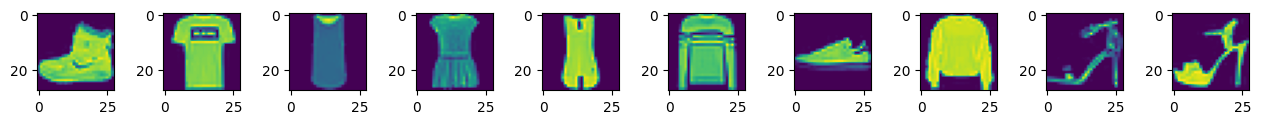

In [7]:
# Adjust for display; high w/h ratio recommended
plt.figure(figsize=(16, 1))

def show_images(dataset, num_samples=10):
    for i, img in enumerate(dataset):
        if i == num_samples:
            return
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(torch.squeeze(img[0]))

show_images(train_set)

Let's set up some import constants for our dataset. With U-Nets, it is common to continually halve the size of the feature map through [Max Pooling](https://paperswithcode.com/method/max-pooling). Then, the feature map size is doubled with [Transposed Convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). To keep the image dimensions consistent as we move down and up the U-Net, it helps if the image size can be divisible by `2` multiple times.

In [8]:
IMG_SIZE = 16 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 1 # Black and white image, no color channels
BATCH_SIZE = 128

Now that we have defined the target size of our images, let's create a function to load the data and transform it to the target size. The random noise we will be adding to our images will be sampled from a [standard normal distribution](https://mathworld.wolfram.com/NormalDistribution.html), meaning 68% of the noise pixel values will be from -1 to 1. We will similarly scale our image values to be from -1 to 1.

This would also be a good place to apply random image augmentation. For now, we will start with a [RandomHorizontalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip). We won't use a [RandomVericalFlip](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomVerticalFlip.html#torchvision.transforms.RandomVerticalFlip) because we would end up generating upside down images.

In [10]:
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_fashionMNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    return torch.utils.data.ConcatDataset([train_set, test_set])

In [11]:
data = load_transformed_fashionMNIST()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13878669.37it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 328229.96it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6130363.01it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 27057991.22it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



## 1.2 The U-Net Architecture

First, let's define the different components of our U-Net architecture. Primarily, the `DownBlock` and the `UpBlock`.

### 1.2.1 The Down Block

The `DownBlock` is a typical convolutional neural network. If you are new to PyTorch and are coming from a Keras/TensorFlow background, the below is more similar to the [functional API](https://keras.io/guides/functional_api/) instead of a [sequential model](https://keras.io/guides/sequential_model/). We will later be using [residual](https://stats.stackexchange.com/questions/321054/what-are-residual-connections-in-rnns) and skip connections. A sequential model does not have the flexibility to support these types of connections, but a functional model does.

In our `__init__` function below, we will assign our various neural network operations to class variables:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) applies convolution to the input. The `in_ch` is the number of channels we are convolving over and `out_ch` is the number of output channels, which is the same as the number of kernel filters used for convolution. Typically in a U-Net architecture, the number of channels increase the further down we move in the model.
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is the activation function for the convolution kernels.
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) applies [batch normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338) to a layer of neurons. ReLu has no learnable parameters, so we can apply the same function to multiple layers and it will have the same effect as using multiple ReLu functions. Batch Normalization does have learnable parameters, and reusing this function can have unexpected effects.
* [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is what we'll use to reduce the size of our feature map as it moves down the network. It's possible to achieve this effect through convolution, but max pooling is commonly used with U-Nets.

In the `forward` method, we describe how are various functions should be applied to an input. So far, the operations are sequential in this order:
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `MaxPool2d`

In [12]:
len("abc")

3

In [13]:
listem = ["ahmet","mehmet","abc","deffff","123456789"]

In [14]:
len(listem)

5

In [15]:
print(listem)

['ahmet', 'mehmet', 'abc', 'deffff', '123456789']


In [16]:
print(*listem)

ahmet mehmet abc deffff 123456789


In [17]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### 1.2.2 The Up Block

While the `DownBlock` reduces the size of our feature map, the `UpBlock` doubles it back up. This is accomplished with [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). We can use almost the same architecture as the `DownBlock`, but we will replace conv2 with convT. The tranpose's `stride` of 2 will cause the doubling with the right amount of `padding`.

Let's get some practice with the code block below. We've set up an example to test out this function by creating a test image of `1`s.

In [18]:
ch, h, w = 1, 3, 3
x = torch.ones(1, ch, h, w)
x

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

We can use the identity `kernel` to see how `conv_transpose2d` alters the input image. The identity kernel has a single `1` value. When used to convolve, the output will be the same as the input.

Try changing the `stride`, `padding`, and `output_padding` below. Do the results match your expectation?

In [19]:
kernel = torch.tensor([[1.]])  # Identity kernel
kernel = kernel.view(1, 1, 1, 1).repeat(1, ch, 1, 1) # Make into a batch

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

The kernel size also impacts the size of the output feature map. Try changing `kernel_size` below. Notice how the output image expands as the kernel size increases? This is the opposite of regular convolution, where a larger kernel size decreases the size of the output feature map.

In [23]:
kernel_size = 3
kernel = torch.ones(1, 1, kernel_size, kernel_size)

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

tensor([[[1., 2., 3., 2., 1.],
         [2., 4., 6., 4., 2.],
         [3., 6., 9., 6., 3.],
         [2., 4., 6., 4., 2.],
         [1., 2., 3., 2., 1.]]])

Another interesting difference: we will be multiplying the input channel by 2. This is to accommodate the skip connections. We will be concatenating the output of an `UpBlock`'s matching `DownBlock` with the `UpBlock`'s input.

<center><img src="images/FMUNet.png" width="600" /></center>

If x is the size of the input feature map, the output size is:

`new_x = (x - 1) * stride + kernel_size - 2 * padding + out_padding`

If stride = 2 and out_padding = 1, then in order to double the size of the input feature map:

`kernel_size = 2 * padding + 1`

The operations are almost the same as before, but with two differences:
* `ConvTranspose2d` - Convolution Transpose instead of Convolution
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* ~~`MaxPool2d`~~ - Scaling up instead of down

In [24]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatednated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

### 1.2.3 A Full U-Net

It's finally time to piece it together! Below, we have our full `UNet` model.

In the `__init__` function, we can define the number of channels at each step of the U-Net with `down_chs`. The current default is `(16, 32, 64)` meaning the current dimensions of the data as it moves through the model are:

* input: 1 x 16 x 16
* down0: 16 x 16 x 16
  * down1: 32 x 8 x 8
    * down2: 64 x 4 x 4
      * dense_emb: 1024
    * up0: 64 x 4 x 4
  * up1: 64 x 8 x 8
* up2: 32 x 16 x 16
* out: 1 x 16 x 16

The `forward` class method is where we will finally add our skip connections. For each step down in the U-Net, we will keep track of the output of each `DownBlock`. Then, when we move through the `UpBlock`s, we will [concatenate](https://pytorch.org/docs/stable/generated/torch.cat.html) the output of the previous `UpBlock` with its corresponding `DownBlock`.

In [25]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_ch = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)
        return self.out(up2)

In [27]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  234977


Let's verify the model architecture with [torchview](https://github.com/mert-kurttutan/torchview). If we have three `down_chs`, there should be two `DownBlock`s, one for each transition. Similarly, there should be two `UpBlock`s. We should also check that there is one skip connection. The "bottom" of the U-Net does not need a skip connection, so there is a skip connection for each `UpBlock` minus one.

Finally, are the output dimensions the same as the input dimensions?

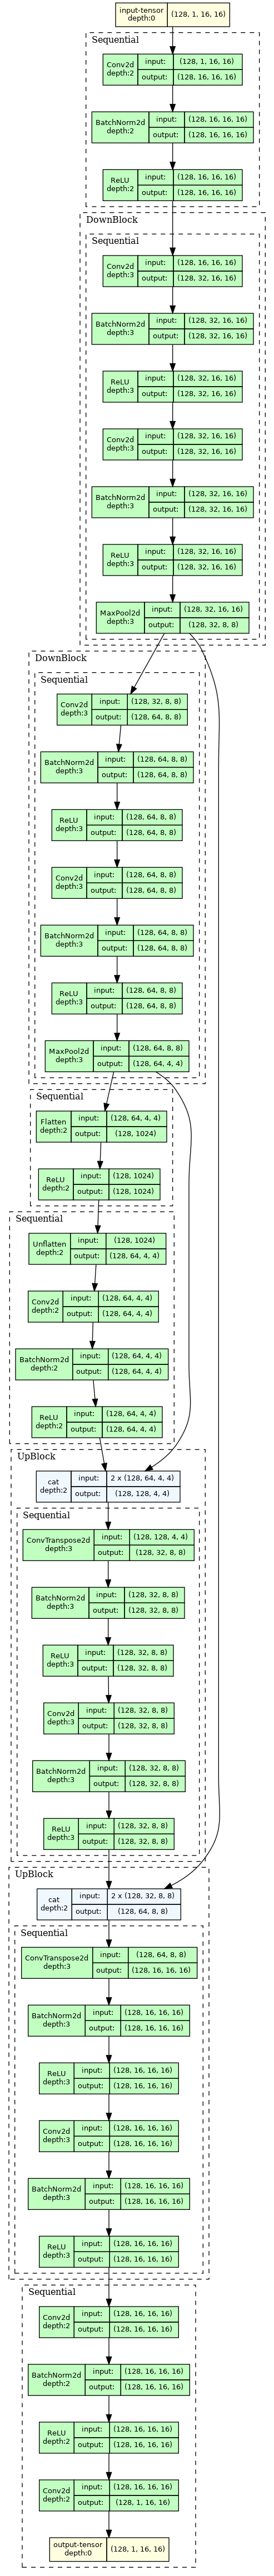

In [28]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(
    model,
    input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE),
    device='meta',
    expand_nested=True
)
model_graph.resize_graph(scale=1.5)
model_graph.visual_graph

In [PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/), we can compile the model to make training faster. It will send the list of operations to our GPU so it can apply those operations to our inputs much like an assembly line. Read more about it [here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

In [29]:
model = torch.compile(UNet().to(device))

## 1.3 Training

Let's try adding noise to our images and see if our U-Net model can filter it out. We can define a parameter `beta` to represent what percentage of our image is noise versus the original image. We can use `alpha` to represent [the compliment](https://brilliant.org/wiki/probability-by-complement/) to `beta`.

In [30]:
def add_noise(imgs):
    dev = imgs.device
    percent = .5 # Try changing from 0 to 1
    beta = torch.tensor(percent, device=dev)
    alpha = torch.tensor(1 - percent, device=dev)
    noise = torch.randn_like(imgs)
    return alpha * imgs + beta * noise

Next, we'll define our loss function as the [Mean Squared Error](https://developers.google.com/machine-learning/glossary#mean-squared-error-mse) between the original image and the predicted image.

In [31]:
def get_loss(model, imgs):
    imgs_noisy = add_noise(imgs)
    imgs_pred = model(imgs_noisy)
    return F.mse_loss(imgs, imgs_pred)

In order to display the output of our model, we will need to convert it back to the format of an image on the CPU.

In [32]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

To see the improvement while training, we can compare the `Original` image, the `Noise Added` image, and the `Predicted Original` image using [subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html).

[@torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html) will skip using this function for calculating the gradient during training.

In [33]:
@torch.no_grad()
def plot_sample(imgs):
    # Take first image of batch
    imgs = imgs[[0], :, :, :]
    imgs_noisy = add_noise(imgs[[0], :, :, :])
    imgs_pred = model(imgs_noisy)

    nrows = 1
    ncols = 3
    samples = {
        "Original" : imgs,
        "Noise Added" : imgs_noisy,
        "Predicted Original" : imgs_pred
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

Finally, it's the moment of truth! It's time to train our model and watch it improve.

Epoch 0 | Step 000 Loss: 0.7909396290779114 


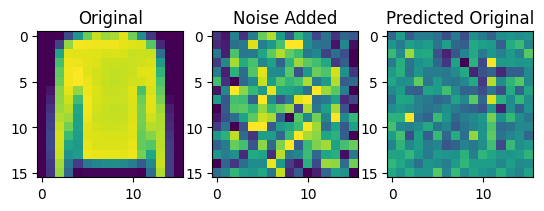

Epoch 0 | Step 100 Loss: 0.10490553826093674 


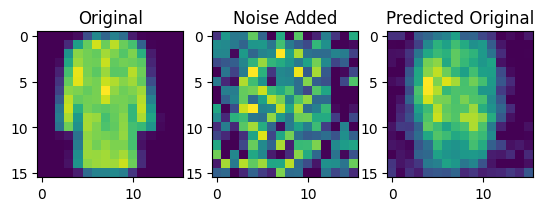

Epoch 0 | Step 200 Loss: 0.07909687608480453 


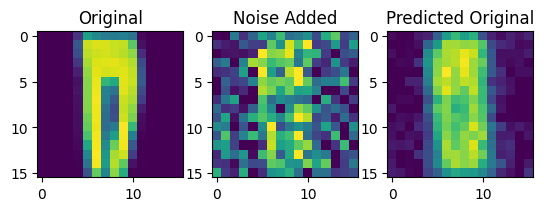

Epoch 0 | Step 300 Loss: 0.06768117100000381 


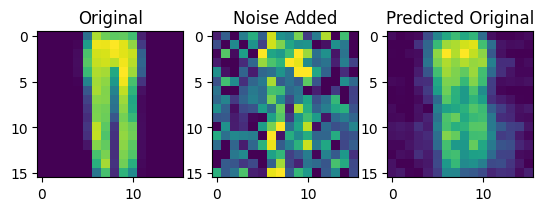

Epoch 0 | Step 400 Loss: 0.06839479506015778 


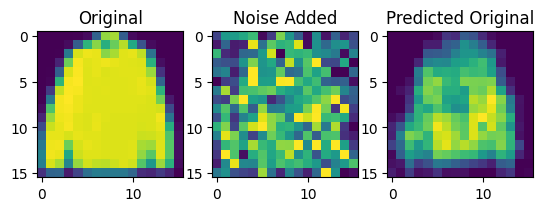

Epoch 0 | Step 500 Loss: 0.06022823229432106 


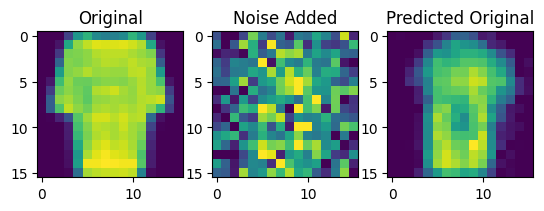

Epoch 1 | Step 000 Loss: 0.06131313741207123 


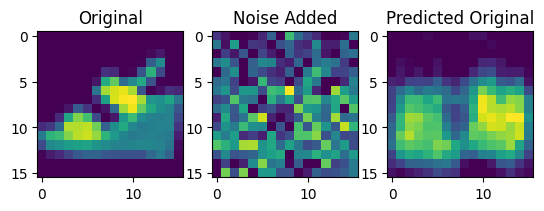

Epoch 1 | Step 100 Loss: 0.05829117074608803 


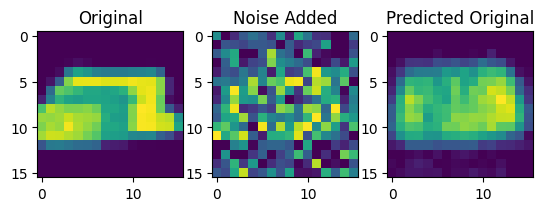

Epoch 1 | Step 200 Loss: 0.059229444712400436 


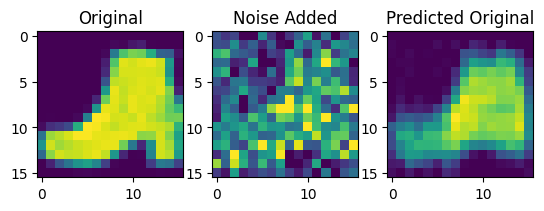

Epoch 1 | Step 300 Loss: 0.05158646032214165 


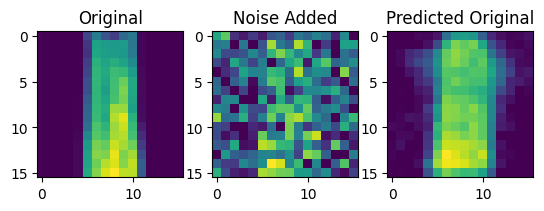

Epoch 1 | Step 400 Loss: 0.05431601032614708 


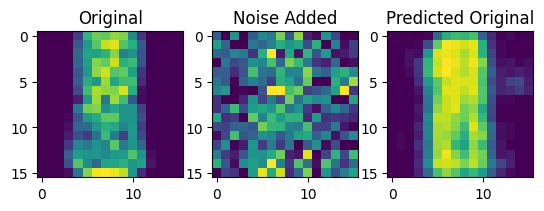

Epoch 1 | Step 500 Loss: 0.05230524018406868 


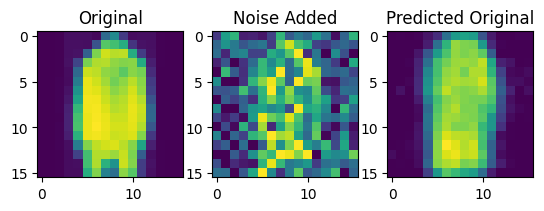

In [34]:
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 2

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        images = batch[0].to(device)
        loss = get_loss(model, images)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ")
            plot_sample(images)

There's a little bit of noise in the predicted image, but it still does a decent job of extracting the original clothing.

Now, how does the model do when given pure noise? Can it create believable new images?

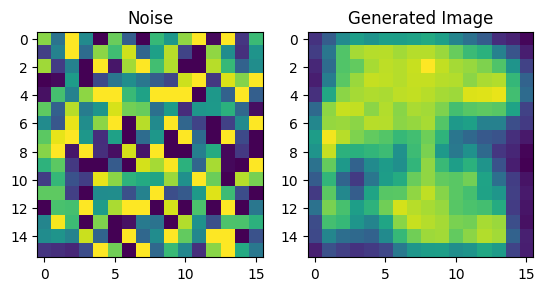

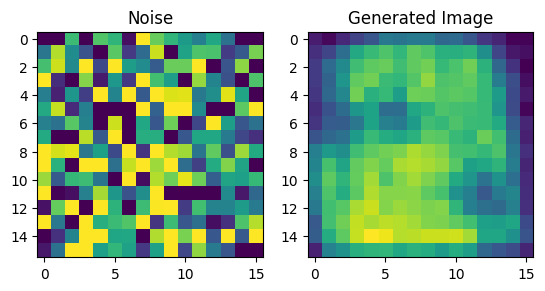

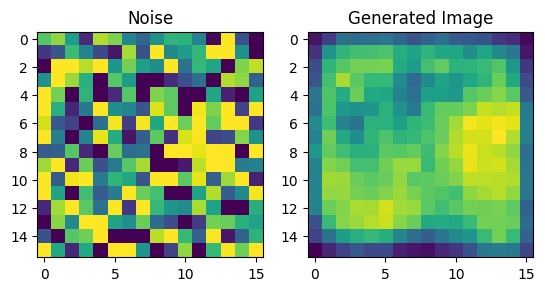

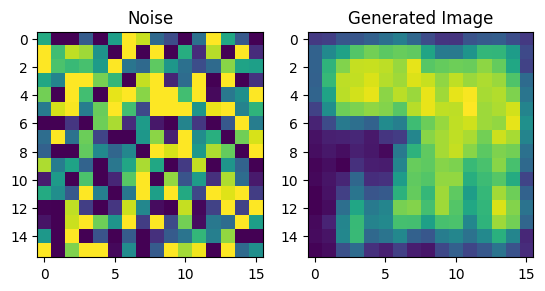

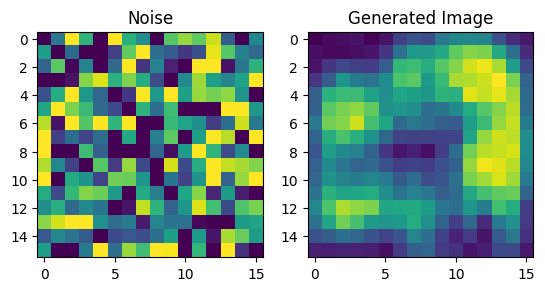

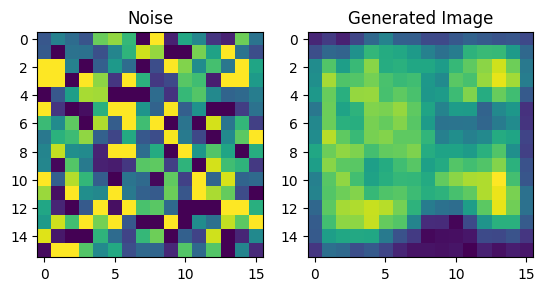

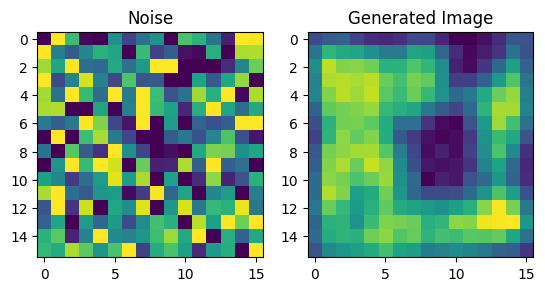

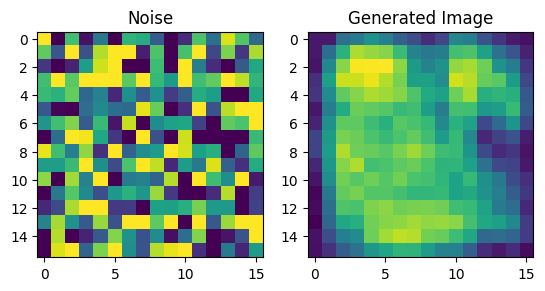

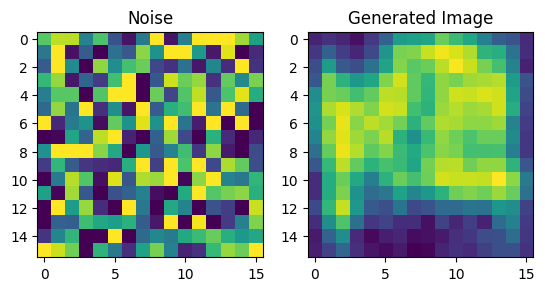

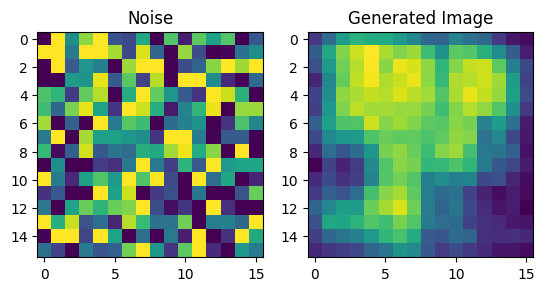

In [35]:
model.eval()
for _ in range(10):
    noise = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)
    result = model(noise)
    nrows = 1
    ncols = 2
    samples = {
        "Noise" : noise,
        "Generated Image" : result
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

## Next

Hmm, these images look more like ink blot images than clothing. In the next notebook, we will improve upon this technique to create more recognizable images.

Before moving on, please restart the jupyter kernel by running the code cell below. This will prevent memory issues in future notebooks.

In [36]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>